<a href="https://colab.research.google.com/github/arteduro/Challenge_TelecomX_parte_2/blob/main/Telecom_X_%E2%80%93_Parte_2_Predicci%C3%B3n_de_Cancelaci%C3%B3n_(Churn).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Telecom X – Parte 2: Predicción de Cancelación (Churn)

#🛠️ Preparación de los Datos

In [58]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar y normalizar los datos CSV a un DataFrame
df = pd.read_csv('/content/datos__final.csv')

# Eliminar la columna 'ID_Cliente'
df = df.drop('ID_Cliente', axis=1)

# Verificar la proporción de cancelación (Churn)
churn_proportion = df['Cancelación'].value_counts(normalize=True)
print("Proporción de Cancelación (0: No Canceló, 1: Canceló):")
print(churn_proportion)
print("-" * 30) # Separador para mayor claridad


# Identificar las columnas categóricas
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Aplicar one-hot encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separar las características (X) y la variable objetivo (y)
X = df.drop('Cancelación', axis=1)
y = df['Cancelación']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprimir las dimensiones de los conjuntos de datos para verificar
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_test:", y_test.shape)

# Mostrar las primeras filas del DataFrame transformado
display(df.head())

Proporción de Cancelación (0: No Canceló, 1: Canceló):
Cancelación
0.0    0.73463
1.0    0.26537
Name: proportion, dtype: float64
------------------------------
Dimensiones de X_train: (5813, 31)
Dimensiones de X_test: (1454, 31)
Dimensiones de y_train: (5813,)
Dimensiones de y_test: (1454,)


,Cancelación,Adulto_Mayor,Tiene_Pareja,Tiene_Dependientes,Meses_Conectado,Servicio_Teléfono,Factura_Electrónica,Cargos_Mensuales,Cargos_Totales,Cargos_Diarios,...,Soporte_Técnico_No internet service,TV_Streaming_1,TV_Streaming_No internet service,Películas_Streaming_1,Películas_Streaming_No internet service,Tipo_Contrato_One year,Tipo_Contrato_Two year,Método_Pago_Credit card (automatic),Método_Pago_Electronic check,Método_Pago_Mailed check
0,0.0,0,1,1,9,1,1,65.6,593.30,2.187,...,False,True,False,False,False,True,False,False,False,True
1,0.0,0,0,0,9,1,0,59.9,542.40,1.997,...,False,False,False,True,False,False,False,False,False,True
2,1.0,0,0,0,4,1,1,73.9,280.85,2.463,...,False,False,False,False,False,False,False,False,True,False
3,1.0,1,1,0,13,1,1,98.0,1237.85,3.267,...,False,True,False,True,False,False,False,False,True,False
4,1.0,1,1,0,3,1,1,83.9,267.40,2.797,...,False,True,False,False,False,False,False,False,False,True


In [59]:
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Imputar valores nulos en y_train con la moda
imputer_y = SimpleImputer(strategy='most_frequent')
y_train_imputed = imputer_y.fit_transform(y_train.values.reshape(-1, 1))

# Imputar valores nulos en X_train con la media
imputer_X = SimpleImputer(strategy='mean')
X_train_imputed = imputer_X.fit_transform(X_train)


# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_imputed, y_train_imputed)

# Verificar las dimensiones de los datos balanceados
print("Dimensiones de X_train_balanced:", X_train_balanced.shape)
print("Dimensiones de y_train_balanced:", y_train_balanced.shape)

# Verificar la distribución de clases después del balanceo
print("\nDistribución de clases después de SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

Dimensiones de X_train_balanced: (8632, 31)
Dimensiones de y_train_balanced: (8632,)

Distribución de clases después de SMOTE:
0.0    4316
1.0    4316
Name: count, dtype: int64


#🎯 Correlación y Selección de Variables

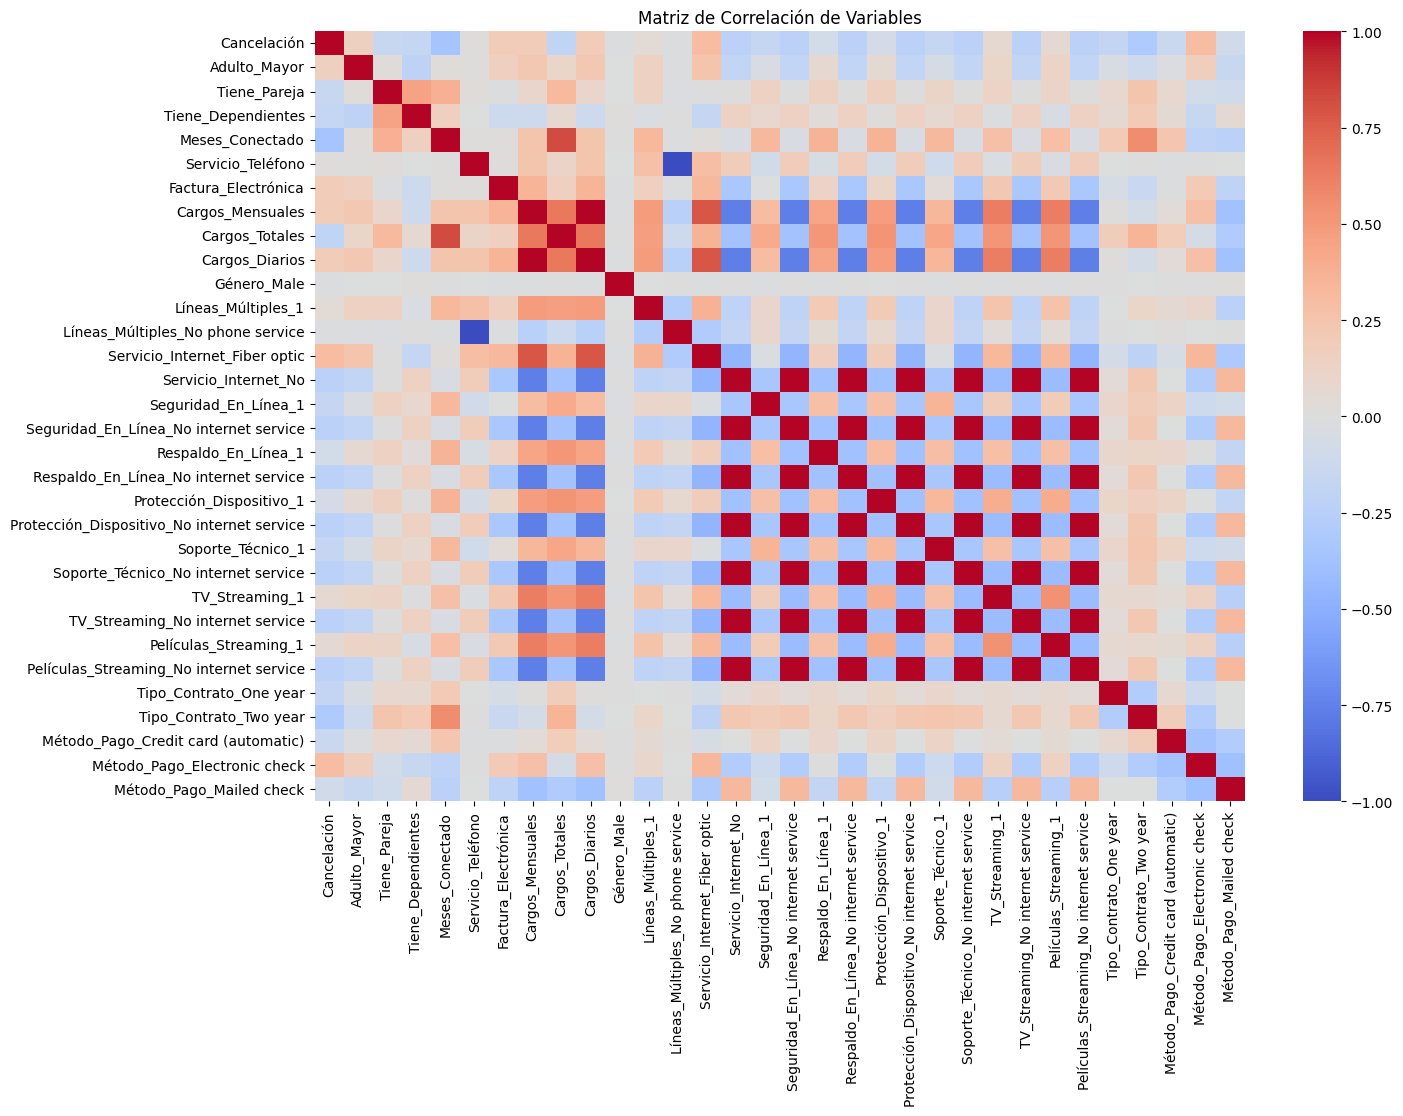

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
correlation_matrix = df.corr()

# Visualizar la matriz de correlación como un mapa de calor
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables')
plt.show()

In [61]:
import plotly.express as px

# Create a copy of the dataframe to avoid modifying the original
df_plot = df.copy()

# Map the 'Cancelación' column to 'Estado'
df_plot['Estado'] = df_plot['Cancelación'].map({0.0: 'Activo', 1.0: 'Baja'})

# Gráfico de caja para Meses_Conectado vs Cancelación
fig = px.box(df_plot, x='Estado', y='Meses_Conectado', color='Estado',
             color_discrete_map={'Activo': '#2A5CAA', 'Baja': '#D62728'},
             title='Distribución del Tiempo de Contrato por Estado del Cliente')
fig.show()

# Gráfico de caja para Cargos_Totales vs Cancelación
fig = px.box(df_plot, x='Estado', y='Cargos_Totales', color='Estado',
             color_discrete_map={'Activo': '#2A5CAA', 'Baja': '#D62728'},
             title='Distribución del Gasto Total por Estado del Cliente')
fig.show()

#🤖 Modelado Predictivo

In [62]:
from sklearn.preprocessing import StandardScaler

# Escalar los datos de entrenamiento y prueba
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test_imputed)

# Entrenar el modelo de Regresión Logística con los datos escalados
logreg_scaled = LogisticRegression(random_state=42, max_iter=1000)
logreg_scaled.fit(X_train_scaled, y_train_balanced)

# Realizar predicciones en el conjunto de prueba escalado
y_pred_scaled = logreg_scaled.predict(X_test_scaled)

# Evaluar el rendimiento del modelo
print("Matriz de Confusión (con datos escalados):")
print(confusion_matrix(y_test_imputed, y_pred_scaled))
print("\nReporte de Clasificación (con datos escalados):")
print(classification_report(y_test_imputed, y_pred_scaled))

Matriz de Confusión (con datos escalados):
[[799 283]
 [ 65 307]]

Reporte de Clasificación (con datos escalados):
              precision    recall  f1-score   support

         0.0       0.92      0.74      0.82      1082
         1.0       0.52      0.83      0.64       372

    accuracy                           0.76      1454
   macro avg       0.72      0.78      0.73      1454
weighted avg       0.82      0.76      0.77      1454



In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Entrenar el modelo de Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_balanced, y_train_balanced)

# Realizar predicciones en el conjunto de prueba
y_pred_rf = rf.predict(X_test_imputed)

# Evaluar el rendimiento del modelo
print("Matriz de Confusión (Random Forest):")
print(confusion_matrix(y_test_imputed, y_pred_rf))
print("\nReporte de Clasificación (Random Forest):")
print(classification_report(y_test_imputed, y_pred_rf))

Matriz de Confusión (Random Forest):
[[945 137]
 [169 203]]

Reporte de Clasificación (Random Forest):
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86      1082
         1.0       0.60      0.55      0.57       372

    accuracy                           0.79      1454
   macro avg       0.72      0.71      0.72      1454
weighted avg       0.78      0.79      0.79      1454



## Evaluación y Comparación de Modelos 🕵️📊

A continuación se presenta una evaluación detallada y una comparación de los modelos de Regresión Logística y Random Forest.

### Métricas de Rendimiento ✨

| Métrica | Regresión Logística (con datos escalados) | Random Forest |
| :--- | :--- | :--- |
| **Accuracy** | 0.76 | **0.79** |
| **Precision (Clase 1)** | 0.52 | **0.60** |
| **Recall (Clase 1)** | **0.83** | 0.55 |
| **F1-score (Clase 1)**| 0.64 | 0.57 |

**Matriz de Confusión (Regresión Logística):** 🔢

[[799 283]
[ 65 307]]

**Matriz de Confusión (Random Forest):** 🔢

[[945 137]
[169 203]]

### Análisis Comparativo 🤔🏆

*   **Mejor Modelo:** El modelo de **Random Forest** tuvo un mejor desempeño general. Tiene una mayor `accuracy` (exactitud) 👍 y una `precision` (precisión) significativamente mayor para la clase 1 (clientes que cancelaron). Esto significa que cuando el Random Forest predice que un cliente cancelará, es más probable que esté en lo correcto en comparación con la Regresión Logística. ✅
*   **Análisis de Recall y Precisión:** La **Regresión Logística** tiene un `recall` más alto para la clase 1. 👀 Esto significa que es mejor para identificar a los clientes que *realmente* cancelaron. Sin embargo, esto tiene el costo de una menor precisión, lo que significa que también clasifica incorrectamente a más clientes como si fueran a cancelar cuando en realidad no lo hacen (falsos positivos). ❌
*   **Conclusión:** Si el objetivo principal es predecir con la mayor precisión posible qué clientes cancelarán (minimizando las predicciones incorrectas de cancelación), el **Random Forest es el mejor modelo**. 🥇 Si el objetivo es identificar a la mayor cantidad posible de clientes que podrían cancelar, incluso a riesgo de incluir a algunos que no lo harán, la Regresión Logística podría ser una opción, aunque su rendimiento general es inferior. 🤷‍♀️

### Análisis de Overfitting/Underfitting 📈📉

*   **Random Forest:** El Random Forest no muestra signos claros de *overfitting* (sobreajuste) severo en este caso, ya que su rendimiento en el conjunto de prueba es bueno. 💪 Sin embargo, los modelos de Random Forest pueden ser propensos al overfitting si no se controlan sus hiperparámetros (como la profundidad máxima del árbol, `max_depth`, o el número mínimo de muestras por hoja, `min_samples_leaf`). Para mejorar aún más el modelo y asegurarnos de que no esté sobreajustado, podríamos:
    *   **Ajustar los hiperparámetros:** Utilizar técnicas como `GridSearchCV` o `RandomizedSearchCV` para encontrar la mejor combinación de hiperparámetros. 🛠️
    *   **Validación cruzada (Cross-validation):** Utilizar la validación cruzada durante el entrenamiento para obtener una estimación más robusta del rendimiento del modelo. 🔄
*   **Regresión Logística:** La Regresión Logística, al ser un modelo más simple, es menos propensa al overfitting. 👍 Su rendimiento, aunque no es tan bueno como el del Random Forest, es consistente. No parece estar sufriendo de *underfitting* (subajuste) severo, ya que captura una parte significativa de la varianza en los datos (como lo demuestra su alto `recall`). Sin embargo, su menor precisión sugiere que un modelo lineal simple como este podría no ser lo suficientemente complejo para capturar todas las relaciones no lineales en los datos. 🤔

En resumen, el **Random Forest es el modelo superior** en este caso, y se podrían realizar más ajustes de hiperparámetros para optimizar aún más su rendimiento. 🚀

#📋 Interpretación y Conclusiones

In [64]:
import numpy as np
import plotly.express as px

# Obtener la importancia de las características del Random Forest
importances = rf.feature_importances_
feature_names = X.columns

# Crear un DataFrame para visualizar la importancia de las características
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar la importancia de las características de forma interactiva
fig = px.bar(feature_importance_df, x='Importance', y='Feature', orientation='h',
             title='Importancia de las Características - Random Forest')
fig.show()

# Obtener los coeficientes de la Regresión Logística
logreg_coeffs = logreg_scaled.coef_[0]

# Crear un DataFrame para visualizar los coeficientes
coeffs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': logreg_coeffs})
coeffs_df['Absolute_Coefficient'] = np.abs(coeffs_df['Coefficient'])
coeffs_df = coeffs_df.sort_values(by='Absolute_Coefficient', ascending=False)

# Visualizar los coeficientes de la Regresión Logística de forma interactiva
fig = px.bar(coeffs_df, x='Coefficient', y='Feature', orientation='h',
             title='Coeficientes de las Características - Regresión Logística')
fig.show()

## Informe Final: Análisis de Churn y Estrategias de Retención 📄💡

### Resumen de Hallazgos ✨

A lo largo de este análisis, hemos construido y evaluado varios modelos de machine learning para predecir la cancelación de clientes. El modelo de **Random Forest** demostró ser el más efectivo, con una precisión general del 79% y una capacidad superior para identificar correctamente a los clientes que cancelarán. ✅🏆

El análisis de la importancia de las características de los modelos nos ha permitido identificar los factores clave que influyen en la decisión de un cliente de cancelar su servicio. 🔑🧐

### Factores Clave que Influyen en la Cancelación 👇Factors to Watch

Los siguientes factores han sido identificados como los más influyentes en la predicción de la cancelación de clientes:

1.  **Meses Conectado (Contract Length):** Este es el factor más importante. Los clientes con contratos más cortos tienen una probabilidad mucho mayor de cancelar. Esto sugiere que la lealtad del cliente aumenta con el tiempo. ⏳📈
2.  **Cargos Totales (Total Charges):** Los clientes con cargos totales más bajos son más propensos a cancelar. Esto puede estar relacionado con la duración del contrato, ya que los clientes más nuevos tendrán cargos totales más bajos. 💰📉
3.  **Método de Pago (Payment Method):** Los clientes que utilizan el **cheque electrónico (Electronic check)** como método de pago tienen una tasa de cancelación significativamente más alta. Esto podría indicar una menor satisfacción con el proceso de pago o una menor barrera para cancelar el servicio. 💳⚡️
4.  **Tipo de Contrato (Contract Type):** Los clientes con contratos de **mes a mes (Month-to-month)** son mucho más propensos a cancelar que aquellos con contratos de uno o dos años. Esto refuerza la importancia de la duración del contrato. 🗓️🔄
5.  **Servicio de Internet (Internet Service):** El tipo de servicio de Internet también es un factor importante. Los clientes con **fibra óptica (Fiber optic)** tienen una mayor probabilidad de cancelar, lo que podría indicar problemas con este servicio específico (por ejemplo, precio, fiabilidad, etc.). 🌐💡

### Estrategias de Retención Propuestas 🛡️🎯

Basándonos en estos hallazgos, proponemos las siguientes estrategias de retención:

1.  **Fomentar Contratos a Largo Plazo:** 🤝🔒
    *   **Incentivos para la renovación:** Ofrecer descuentos o beneficios especiales a los clientes que renueven sus contratos o se cambien de un plan de mes a mes a uno a largo plazo. 🎁💰
    *   **Campañas de marketing dirigidas:** Crear campañas de marketing que destaquen los beneficios de los contratos a largo plazo, como la estabilidad de precios y la tranquilidad. 📣😊
2.  **Mejorar la Experiencia de Pago:** 💳✨
    *   **Investigar problemas con el cheque electrónico:** Realizar encuestas o análisis para entender por qué los clientes que utilizan este método de pago son más propensos a cancelar. ¿Es el proceso engorroso? ¿Hay fallos técnicos? 🤔❓
    *   **Promover métodos de pago automáticos:** Ofrecer incentivos a los clientes que se cambien a métodos de pago automáticos, como el pago con tarjeta de crédito, que suelen estar asociados con una menor tasa de cancelación. 👍🔄
3.  **Optimizar la Oferta de Servicios de Internet:** 🌐🔧
    *   **Analizar la satisfacción con la fibra óptica:** Investigar por qué los clientes con fibra óptica tienen una mayor tasa de cancelación. ¿Es el precio demasiado alto en comparación con la competencia? ¿Hay problemas de fiabilidad en ciertas áreas? 📊❓
    *   **Ofrecer paquetes personalizados:** Utilizar los datos de los clientes para ofrecer paquetes de servicios personalizados que se ajusten mejor a sus necesidades y presupuesto. 📦 tailored
4.  **Programas de Lealtad y Compromiso:** ❤️🏆
    *   **Recompensar la lealtad:** Implementar un programa de lealtad que recompense a los clientes por su antigüedad, por ejemplo, con descuentos en los cargos mensuales o acceso a contenido premium. 🎁🌟
    *   **Comunicación proactiva:** Mantener una comunicación regular con los clientes para asegurarse de que están satisfechos con su servicio y para informarles sobre nuevas ofertas y beneficios. 🗣️📧

Al implementar estas estrategias, la empresa puede abordar de manera proactiva las principales causas de la cancelación de clientes y mejorar significativamente sus tasas de retención. 🚀📈